# Packages loading 

In [2]:
import keras
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, Input, Lambda, Conv2DTranspose
from keras.layers import Activation, UpSampling2D, BatchNormalization, Reshape, concatenate
from keras.models import Sequential, Input, Model
from keras.utils.np_utils import to_categorical
import matplotlib.patches as patches
import matplotlib.pyplot as plt
from keras import backend as K
from keras import optimizers
%matplotlib inline
import numpy as np
import cv2
from keras.models import Model
from skimage.transform import iradon_sart
from skimage.transform import iradon, radon
from keras.callbacks import TensorBoard

# Data pre-processing

### Projection matrix

In [3]:
import scipy.io
mat = scipy.io.loadmat('thinL64_90.mat')
A = mat['H'].todense()

### Training Data

In [4]:
import h5py
brains = []
N = int(0.95*767)
for i in range(1, 767):
    with  h5py.File('brains-master/%s.mat' %i, 'r') as f:
        brain = np.array(f['cjdata']['image'])
        brain = brain[::8, ::8]
        brains += [brain]

brains = np.array(brains)
brains_train = np.array(brains)[0:N-1]
print(brains_train.shape)

(727, 64, 64)


### Gaussian noising

In [5]:
mean = 0
sigma = 150

row,col = brains[0].shape
gauss = np.random.normal(mean,sigma,(row,col))
gauss = gauss.reshape(row,col)
noisy_brains = []
for image in brains:
    noisy_brains.append(image + gauss)
noisy_brains = np.array(noisy_brains)

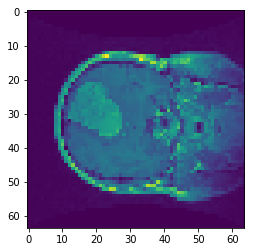

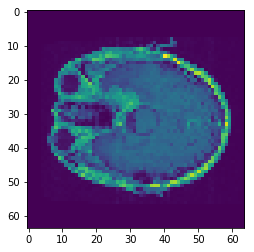

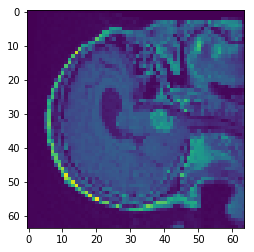

In [82]:
plt.figure(1)
plt.imshow(brains[300])
plt.show()
plt.figure(2)
plt.imshow(brains[100])
plt.show()
plt.figure(3)
plt.imshow(brains[500])
plt.show()

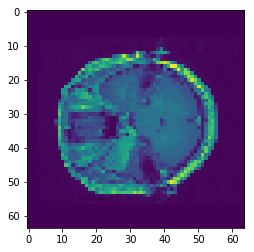

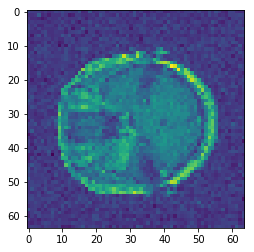

In [6]:
plt.figure(1)
plt.imshow(brains[0])
plt.show()
plt.figure(1)
plt.imshow(noisy_brains[0])
plt.show()

### Projections of the noisy images

#### projections with given matrix

In [7]:
projections_noisy_brains = []
for i in range(noisy_brains.shape[0]):
    p = np.matmul(A, noisy_brains[i].flatten())
    p = p.reshape((90,90))
    projections_noisy_brains += [p]
    
projections_noisy_brains = np.array(projections_noisy_brains)
print(projections_noisy_brains.shape)

(766, 90, 90)


#### projections with Radon Transform

In [8]:
theta = np.array(range(0,180))
radon_noisy_brains = []
for i in range(noisy_brains.shape[0]):
    p = radon(noisy_brains[i], theta=theta, circle=True)
    radon_noisy_brains += [p]
    
radon_noisy_brains = np.array(radon_noisy_brains)
print(radon_noisy_brains.shape)

/Users/baptiste_doyen/anaconda3/lib/python3.6/site-packages/skimage/transform/radon_transform.py:69: UserWarning: Radon transform: image must be zero outside the reconstruction circle
  warn('Radon transform: image must be zero outside the '


(766, 64, 180)


### FBP of the projections of the noisy images

In [10]:
fbp_radon_noisy_brains = []

for i in range(radon_noisy_brains.shape[0]):
    reconstruction_fbp = iradon(radon_noisy_brains[i], theta=theta, circle=True)
    fbp_radon_noisy_brains += [reconstruction_fbp]
    
fbp_radon_noisy_brains = np.array(fbp_radon_noisy_brains)
print(fbp_radon_noisy_brains.shape)

(766, 64, 64)


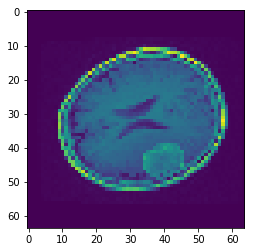

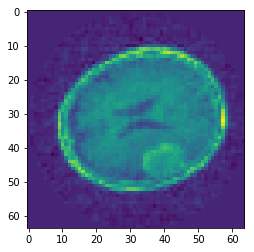

In [12]:
plt.figure(1)
plt.imshow(brains[50])
plt.show()
plt.figure(1)
plt.imshow(fbp_radon_noisy_brains[50])
plt.show()

# Denoising autoencoder

In [21]:
# rescaling data

brains_scaled = []
for img in brains:
    img = img/np.max(img)
    brains_scaled += [img]
brains_scaled = np.array(brains_scaled)

fbp_noisy_scaled = []
for img in fbp_radon_noisy_brains:
    img = img/np.max(img)
    fbp_noisy_scaled += [img]
fbp_noisy_scaled = np.array(fbp_noisy_scaled)

In [58]:
X_train = fbp_noisy_scaled[0:N-1].reshape(brains_scaled[0:N-1].shape[0], 64, 64, 1)
Y_train = brains_scaled[0:N-1].reshape(brains_scaled[0:N-1].shape[0], 64, 64, 1)

X_test = fbp_noisy_scaled[N:].reshape(brains_scaled[N:].shape[0], 64, 64, 1)
Y_test = brains_scaled[N:].reshape(brains_scaled[N:].shape[0], 64, 64, 1)

In [66]:
input_img = Input(shape=(64, 64, 1)) 

# encoder
conv1_encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(input_img)
conv2_encoder = Conv2D(32, (3, 3), activation='relu', padding='same')(conv1_encoder)
max1 = MaxPooling2D((2, 2), padding='same')(conv2_encoder)

conv3_encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(max1)
conv4_encoder = Conv2D(16, (3, 3), activation='relu', padding='same')(conv3_encoder)
max2 = MaxPooling2D((2, 2), padding='same')(conv4_encoder)

conv5_encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(max2)
conv6_encoder = Conv2D(8, (3, 3), activation='relu', padding='same')(conv5_encoder)
drop1 = Dropout(0.5)(conv6_encoder)

encoded = MaxPooling2D((2, 2), padding='same')(drop1)

# decoder

conv1_decoder = Conv2D(8, (3, 3), activation='relu', padding='same')(encoded)
conv2_decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(conv1_decoder)
drop2 = Dropout(0.5)(conv2_decoder)
up1 = UpSampling2D((2, 2))(drop2)
merge1 = concatenate([drop1,up1], axis = 3)

conv3_decoder = Conv2D(16, (3, 3), activation='relu', padding='same')(merge1)
conv4_decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(conv3_decoder)
up2 = UpSampling2D((2, 2))(conv4_decoder)
merge2 = concatenate([conv4_encoder,up2], axis = 3)

conv5_decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(merge2)
conv6_decoder = Conv2D(32, (3, 3), activation='relu', padding='same')(conv5_decoder)
up3 = UpSampling2D((2, 2))(conv6_decoder)
merge3 = concatenate([conv2_encoder,up3], axis = 3)

decoded = Conv2D(1, (2, 2), activation='sigmoid', padding='same')(merge3)

# model
autoencoder = Model(input_img, decoded)
adam = optimizers.Adam(lr=0.001)
autoencoder.compile(optimizer=adam, loss='binary_crossentropy')
autoencoder.summary()
autoencoder.fit(X_train,Y_train,batch_size=32,epochs=200, verbose=1, validation_data=(X_test, Y_test),
                callbacks=[TensorBoard(log_dir='/tmp/autoencoder')])

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_17 (InputLayer)        (None, 64, 64, 1)         0         
_________________________________________________________________
conv2d_183 (Conv2D)          (None, 64, 64, 32)        320       
_________________________________________________________________
conv2d_184 (Conv2D)          (None, 64, 64, 32)        9248      
_________________________________________________________________
max_pooling2d_49 (MaxPooling (None, 32, 32, 32)        0         
_________________________________________________________________
conv2d_185 (Conv2D)          (None, 32, 32, 16)        4624      
_________________________________________________________________
conv2d_186 (Conv2D)          (None, 32, 32, 16)        2320      
_________________________________________________________________
max_pooling2d_50 (MaxPooling (None, 16, 16, 16)        0         
__________

727/727 [==============================] - 23s - loss: 0.3282 - val_loss: 0.2887
Epoch 50/200
727/727 [==============================] - 22s - loss: 0.3277 - val_loss: 0.2892
Epoch 51/200
727/727 [==============================] - 22s - loss: 0.3277 - val_loss: 0.2882
Epoch 52/200
727/727 [==============================] - 22s - loss: 0.3277 - val_loss: 0.2885
Epoch 53/200
727/727 [==============================] - 22s - loss: 0.3278 - val_loss: 0.2886
Epoch 54/200
727/727 [==============================] - 22s - loss: 0.3275 - val_loss: 0.2882
Epoch 55/200
727/727 [==============================] - 22s - loss: 0.3279 - val_loss: 0.2890
Epoch 56/200
727/727 [==============================] - 22s - loss: 0.3276 - val_loss: 0.2884
Epoch 57/200
727/727 [==============================] - 22s - loss: 0.3276 - val_loss: 0.2883
Epoch 58/200
727/727 [==============================] - 23s - loss: 0.3276 - val_loss: 0.2888
Epoch 59/200
727/727 [==============================] - 23s - loss: 0.327

727/727 [==============================] - 23s - loss: 0.3258 - val_loss: 0.2871
Epoch 136/200
727/727 [==============================] - 23s - loss: 0.3260 - val_loss: 0.2871
Epoch 137/200
727/727 [==============================] - 22s - loss: 0.3258 - val_loss: 0.2871
Epoch 138/200
727/727 [==============================] - 22s - loss: 0.3259 - val_loss: 0.2872
Epoch 139/200
727/727 [==============================] - 23s - loss: 0.3261 - val_loss: 0.2873
Epoch 140/200
727/727 [==============================] - 22s - loss: 0.3259 - val_loss: 0.2871
Epoch 141/200
727/727 [==============================] - 22s - loss: 0.3258 - val_loss: 0.2878
Epoch 142/200
727/727 [==============================] - 22s - loss: 0.3258 - val_loss: 0.2871
Epoch 143/200
727/727 [==============================] - 23s - loss: 0.3258 - val_loss: 0.2871
Epoch 144/200
727/727 [==============================] - 22s - loss: 0.3257 - val_loss: 0.2873
Epoch 145/200
727/727 [==============================] - 22s - l

In [67]:
autoencoder.save('denoiser.h5')

In [324]:
denoised_train = autoencoder.predict(fbp_radon_noisy_brains[0].reshape(1,64,64,1)/np.max(fbp_radon_noisy_brains[0]))

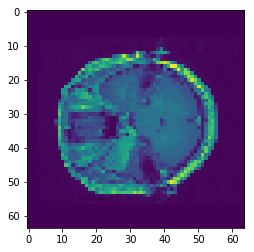

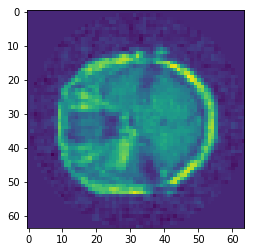

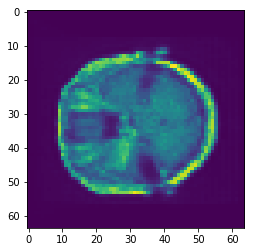

In [325]:
plt.figure(1)
plt.imshow(brains_scaled[0])
plt.show()
plt.figure(2)
plt.imshow(fbp_noisy_scaled[0])
plt.show()
plt.figure(3)
plt.imshow(denoised_train.reshape(64,64))
plt.show()

# ADMM Algorithm with U-Net Denoiser

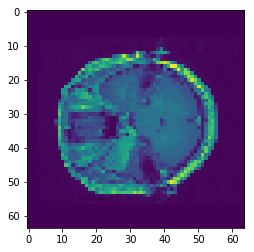

In [84]:
plt.figure(2)
plt.imshow(brains_scaled[0])
plt.show()

In [155]:
cortex = brains_scaled[0]

In [156]:
p = np.matmul(A, cortex.flatten())

In [225]:
# noisy image
z = p.reshape(90,90)

In [182]:
e = [a for a in list(np.array(A).flatten()) if a!=0]

In [347]:
max_iter = 30
tol = 1e-4
h_beta = 8.
g_beta = 10.
gamma = 5.
low = 0.
high = 255.
x_init = np.dot(A.T,z.flatten().T)

def g_grad(x):
    return np.dot(A.T, np.dot(A, x.flatten().T).flatten().T - z.flatten().T)

def h_prox(x):
    return autoencoder.predict(x.reshape(1,64,64,1)/np.max(x))

def f(x):
    if np.all(low <= x) and np.all(x <= high):
        return 0
    else:
        return np.inf
    
def f_prox(x):
    return max(low,np.min(x.flatten() + [high]))

def g(x):
    return 0.5*np.linalg.norm(np.matmul(A, x.flatten().T) - z.flatten().T)

def h(x):
    xx = np.sqrt(np.sum( np.square(x)))
    return np.sum( gamma * xx )      


# step-sizes
tau   = 2.0 / (g_beta + 2.0)
sigma = (1.0/tau - g_beta/2.0) / h_beta

# initialization
x = x_init
y = np.matmul(A, x.flatten().T).reshape(90,90)

print('Running FBPD...')
    
timing = np.zeros(max_iter)
criter = np.zeros(max_iter)

# algorithm loop
for it in range(0, max_iter):
    
    t = time.time()
    
    # primal forward-backward step
    x_old = x;
    x = x - tau*(g_grad(x) + np.dot(A.T,y.flatten().T))
    #x = f_prox(x)
    
    # dual forward-backward step
    y = y + sigma*np.dot(A,(2*x - x_old).flatten().T).reshape(90,90)
    y = np.dot(A, h_prox(np.array(np.dot(A.T,y.flatten().T))).reshape(64,64).flatten().T).reshape(90,90)

    # time and criterion
    timing[it] = time.time() - t
    criter[it] = f(x) + g(x) + h(np.dot(A,x.flatten().T))
           
    # stopping rule
    if np.linalg.norm(x - x_old) < tol * np.linalg.norm(x_old) and it > 10:
        break
    
    print(str(it)+'=out of'+str(max_iter)+'iterations')

criter = criter[0:it+1]
timing = np.cumsum(timing[0:it+1])

Running FBPD...
0=out of30iterations
1=out of30iterations
2=out of30iterations
3=out of30iterations
4=out of30iterations
5=out of30iterations
6=out of30iterations
7=out of30iterations
8=out of30iterations
9=out of30iterations
10=out of30iterations
11=out of30iterations
12=out of30iterations
13=out of30iterations
14=out of30iterations
15=out of30iterations
16=out of30iterations
17=out of30iterations
18=out of30iterations
19=out of30iterations
20=out of30iterations
21=out of30iterations
22=out of30iterations
23=out of30iterations
24=out of30iterations
25=out of30iterations
26=out of30iterations
27=out of30iterations
28=out of30iterations
29=out of30iterations


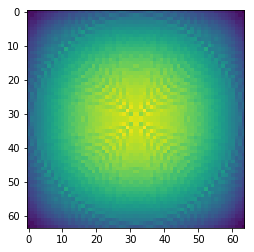

In [350]:
plt.figure(2)
plt.imshow(x.reshape(64,64))
plt.show()

In [ ]:
x, it, timing, criter

Text(0,0.5,'criterion')

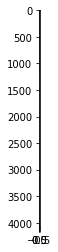

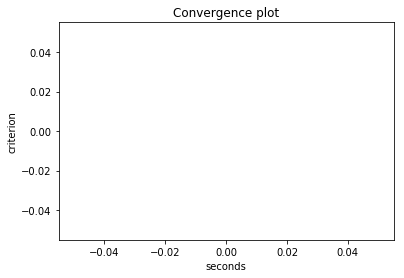

In [355]:
# PSNR
psnr = 10 * np.log10( 255*255 / np.mean(np.square(x-x_bar)) )

# visualization
plt.imshow(x/255); 
plt.title( 'Restored image - PSNR: ' + str(np.round(psnr,2)) )
plt.figure()
plt.plot(timing, criter) 
plt.title('Convergence plot')
plt.xlabel('seconds')
plt.ylabel('criterion')